## Import CTH-UHB Intrapartum CTG Records

This notebook provides an example of importing a FHR and UC record from the open CTH-UHB Intrapartum database on PhysioNet. 

In [4]:
%matplotlib inline

#Import the waveform database library
import wfdb
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import fhrpreproc as fhrpre
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz

In [ ]:
#Load Physionet databases recognized by the library
dblist = wfdb.getdblist()

In [ ]:
#Print List of databases
print (dblist)

In [ ]:
#Download the desired database to a local directory
wfdb.dldatabase('ctu-uh b-ctgdb', '/Users/humza/Google Drive/nanodegree/machine-learning-master/projects/capstone/fetal_heart_rate/RawData', records = 'all', annotators = 'all',
           keepsubdirs = True, overwrite = False)


In [5]:
#Set path to downloaded data
path = '/Users/humza/Google Drive/nanodegree/machine-learning-master/projects/capstone/fetal_heart_rate/RawData'

In [6]:
#Import List of Record Names without .hea extension

data = pd.read_csv("RECORDS.csv")
recordList = data['RECORDS']


In [ ]:
#Create a record object by reading one subjects data
record = wfdb.rdsamp(path + '/1002', sampfrom=0, sampto=None, channels=None,
                physical=True, pbdir = None, m2s=True)


In [7]:
index = 0
pH = []
delType = []

FHRmeanStage1 = []
FHRvarStage1 = []
nAccStage1 = []
nDecStage1 = []
EnVLFStage1 = []
EnLFStage1 = []
EnHFStage1 = []

FHRmeanStage2 = []
FHRvarStage2 = []
nAccStage2 = []
nDecStage2 = []
EnVLFStage2 = []
EnLFStage2 = []
EnHFStage2 = []

for subject in recordList:
    record = wfdb.rdsamp(path + '/' + str(subject), sampfrom=0, sampto=None, channels=None,
                    physical=True, pbdir = None, m2s=True)
    FHRpreproc = fhrpre.FHRpreproc(record)
    FHRpreproc.parseHeader()
    pH.append(FHRpreproc.pH)
    delType.append(FHRpreproc.delType)
    LaborSigs = FHRpreproc.sepLaborSigs()
    
    trimStage1 = FHRpreproc.trimSignal(LaborSigs[0],150)
    compStage1 = FHRpreproc.compSignal(trimStage1)
    FHRmeanStage1.append(FHRpreproc.calcFHRMean(compStage1))
    FHRvarStage1.append(FHRpreproc.calcFHRVariability(compStage1))
    nAccStage1.append(FHRpreproc.calcAcc(compStage1,FHRmeanStage1[index],15))
    nDecStage1.append(FHRpreproc.calcDec(compStage1,FHRmeanStage1[index],15))
    EnergyStage1 = FHRpreproc.calcEnergy(compStage1,FHRmeanStage1[index],0.03,0.15,0.5)
    EnVLFStage1.append(EnergyStage1[0])
    EnLFStage1.append(EnergyStage1[1])
    EnHFStage1.append(EnergyStage1[2])
    
    compStage2 = FHRpreproc.compSignal(LaborSigs[2])
    if len(compStage2) > 1200:
        FHRmeanStage2.append(FHRpreproc.calcFHRMean(compStage2))
        FHRvarStage2.append(FHRpreproc.calcFHRVariability(compStage2))
    else:
        FHRmeanStage2.append(np.nan)
        FHRvarStage2.append(np.nan)
    
    if len(compStage2) > 1200:
        nAccStage2.append(FHRpreproc.calcAcc(compStage2,FHRmeanStage2[index],15))
        nDecStage2.append(FHRpreproc.calcDec(compStage2,FHRmeanStage2[index],15))
        EnergyStage2 = FHRpreproc.calcEnergy(compStage2,FHRmeanStage2[index],0.03,0.15,0.5)
        EnVLFStage2.append(EnergyStage2[0])
        EnLFStage2.append(EnergyStage2[1])
        EnHFStage2.append(EnergyStage2[2])
    else:
        nAccStage2.append(np.nan)
        nDecStage2.append(np.nan)
        EnVLFStage2.append(np.nan)
        EnLFStage2.append(np.nan)
        EnHFStage2.append(np.nan)
    index = index + 1
    
display(np.mean(FHRmeanStage1),np.mean(FHRvarStage1))
display(np.mean(nAccStage1),np.mean(nDecStage1),np.mean(EnVLFStage1),np.mean(EnLFStage1),np.mean(EnHFStage1))

display(np.nanmean(FHRmeanStage2),np.nanmean(FHRvarStage2))
display(np.nanmean(nAccStage2),np.nanmean(nDecStage2),np.nanmean(EnVLFStage2),np.nanmean(EnLFStage2),np.nanmean(EnHFStage2))



136.17838225681228

15.069809395484015

4.7282608695652177

5.4637681159420293

77369252084442256.0

275.75447690912222

916.09760166251795

126.56267540162597

21.047043620707861

3.017994858611825

3.3341902313624678

1.1710814013854285e+36

138.22199671712897

299.57059619116154

In [8]:
labelStage1 = np.repeat(1,len(recordList))
labelStage2 = np.repeat(2,len(recordList))

Stage1FHRFeat = pd.DataFrame({'record': recordList,'pH': pH,'delType': delType,'FHRmean': FHRmeanStage1,
                            'FHRvar':FHRvarStage1,'nAcc':nAccStage1,
                            'nDec':nDecStage1,'EnVLF':EnVLFStage1,'EnLF':EnLFStage1,
                            'EnHF':EnHFStage1,'StageLabel':labelStage1})

Stage2FHRFeat = pd.DataFrame({'record': recordList,'pH': pH,'delType': delType,'FHRmean': FHRmeanStage2,
                            'FHRvar':FHRvarStage2,'nAcc':nAccStage2,
                            'nDec':nDecStage2,'EnVLF':EnVLFStage2,'EnLF':EnLFStage2,
                            'EnHF':EnHFStage2,'StageLabel':labelStage2})



include = Stage1FHRFeat[Stage1FHRFeat['pH']>7.14]
include = include[include['delType']==1]
include = include.dropna()
display(len(include))

include2 = Stage2FHRFeat[Stage1FHRFeat['pH']>7.14]
include2 = include2[include2['delType']==1]
include2 = include2.dropna()
display(len(include2))

combinedData = pd.concat([Stage1FHRFeat, Stage2FHRFeat], axis = 0)
combinedData = combinedData[combinedData['pH']>7.14]
combinedData = combinedData[combinedData['delType']==1]
combinedData=combinedData.dropna()

display(len(combinedData))

X = combinedData.drop(['pH','delType','record','StageLabel','EnVLF'],axis=1)

Y=combinedData['StageLabel']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

417

274

691

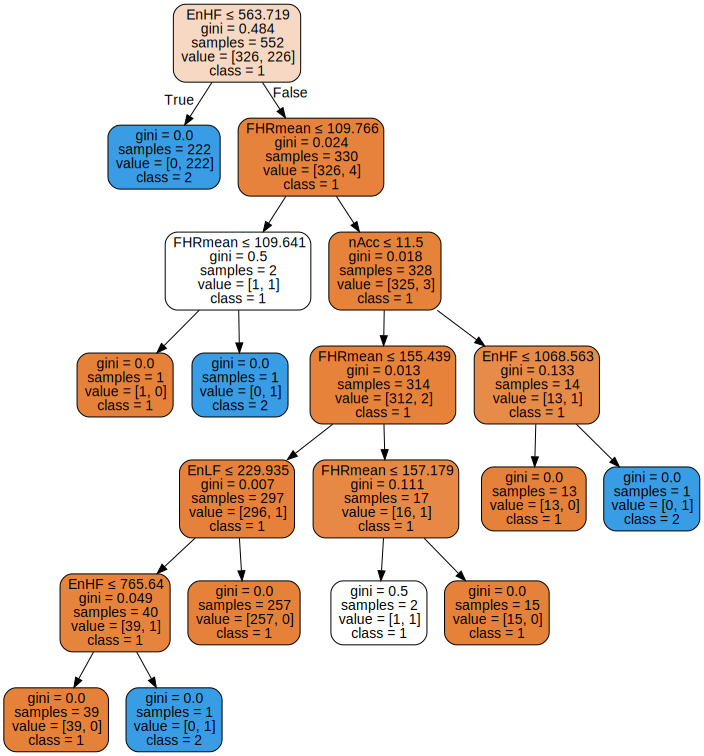

In [11]:
DecTree = DecisionTreeClassifier()
DecTree.fit(X_train,Y_train)
P=DecTree.predict(X_test)
DecTree.score(X_test,Y_test)

dot=tree.export_graphviz(DecTree, out_file=None,
    feature_names=X_train.columns,
    class_names="12",
    filled=True, rounded=True,
    special_characters=True)

graph=graphviz.Source(dot)
graph

In [ ]:
#Use wfdb library to plot records
wfdb.plotrec(record)

In [ ]:
#Print and Gather some useful record characteristics
#View sampling frequency
print (record.fs)
#FHR Signal Length
#First column of p_signals is FHR
siglen = len(record.p_signals[:,0])
print(siglen)
#std = np.std(a[:,0])
#print(std)
#a = np.mean(a[np.nonzero(a[:,0])])
#print(a)

headerInfo=record.comments
#Isolate pH
pHstring = headerInfo[2]
pHmatch=re.search('pH\s*(\d+.\d+)',pHstring)
pHmatch2= re.search('pH\s*(\d+)',pHstring)
if pHmatch:
    pH = float(pHmatch.group(1))
if pHmatch2:
    ph = float(pHmatch2.group(1))
    print(ph)
print("ph found:",ph)

#Pos stage II- This is position in raw signal sample not an index of an array
posStage2String = headerInfo[40]
posStage2 = re.search('Pos. II.st.\s*(\d+)',posStage2String)
if posStage2:
    posStage2 = int(posStage2.group(1))
print("Position of Stage II is:",posStage2)

#Delivery Type
delTypeString = headerInfo[36]
delType = re.search('Deliv. type\s*(\d+)',delTypeString)
if delType:
    delType = int(delType.group(1))
print("Delivery Type is",delType)

In [ ]:
#Separate Stage I Signal
Stage1Sig = record.p_signals[0:posStage2,0]
Stage1len = len(Stage1Sig)
#print("Length of Stage I is: ",Stage1len," datapoints and ", Stage1len)/4, " sec")))
print("Length of Stage I is: %d datapoints and %.2f seconds" % (Stage1len,Stage1len/4))
#Separate Stage II Signal
Stage2Sig = record.p_signals[posStage2:,0]
Stage2len = len(Stage2Sig)
print("Length of Stage 2 is: %d datapoints and %.2f seconds" % (Stage2len,Stage2len/4))

In [ ]:
#Set Time Length to remove samples from beginning or end of sample
#This is time potentially confounding signal if equipment just started/ended acquisition

#Define Excluded Time-Frame in seconds and number of samples
excTimeFrameSecs = 150
excTimeFrameSamp = 150*4
#Compress by removing zero elements from each when a signal was not able to be acquired
Stage1SigTrim = Stage1Sig[excTimeFrameSamp:]
print("Stage I trimmed length is: %d datapoints and %.2f seconds" % (len(Stage1SigTrim),len(Stage1SigTrim)/4))
Stage2SigTrim = Stage2Sig[0:Stage2len-excTimeFrameSamp]
print("Stage II trimmed length is: %d datapoints and %.2f seconds" % (len(Stage2SigTrim),len(Stage2SigTrim)/4))

#Compress each Signal by removing zero elements
Stage1SigComp = Stage1SigTrim[np.nonzero(Stage1SigTrim)]
Stage2SigComp = Stage2SigTrim[np.nonzero(Stage2SigTrim)]
print("Stage I Compressed length is: %d datapoints and %.2f seconds" % (len(Stage1SigComp),len(Stage1SigComp)/4))
print("Stage II Compressed length is: %d datapoints and %.2f seconds" % (len(Stage2SigComp),len(Stage2SigComp)/4))



In [ ]:
Stage1FHRMean = np.mean(Stage1SigComp)
Stage1HRV = np.std(Stage1SigComp)
Stage2FHRMean = np.mean(Stage2SigComp)
Stage2HRV = np.std(Stage2SigComp)

print("Stage I Compressed Signal Mean: %.2f and HRV: %.2f" % (Stage1FHRMean,Stage1HRV))
print("Stage 2 Compressed Signal Mean: %.2f and HRV: %.2f" % (Stage2FHRMean,Stage2HRV))


In [ ]:
#Acceleration Detection Stage I

#Calculation of acceleration minimum detection time in number of samples
minAccDur = 15 #seconds
minAccSamp = minAccDur*record.fs
print(minAccSamp)

count = 0
prevCheck = 0
nAcc = 0
for i in range(len(Stage1SigComp)):
    if Stage1SigComp[i] > (Stage1FHRMean+15):
        count=count+1
    #    print(count)
    else:
        if (count > minAccSamp):
#            print("YES")
            nAcc = nAcc+1
        count = 0       

print(nAcc)



In [ ]:
#Acceleration Detection Stage II

#Calculation of acceleration minimum detection time in number of samples
minAccDur = 15 #seconds
minAccSamp = minAccDur*record.fs
print(minAccSamp)

count = 0
prevCheck = 0
nAcc = 0
for i in range(len(Stage2SigComp)):
    if Stage2SigComp[i] > (Stage2FHRMean+15):
        count=count+1
    #    print(count)
    else:
        if (count > minAccSamp):
#            print("YES")
            nAcc = nAcc+1
        count = 0       

print(nAcc)

In [ ]:
#Decelerations Detection Stage I

#Calculation of acceleration minimum detection time in number of samples
minAccDur = 15 #seconds
minAccSamp = minAccDur*record.fs
print(minAccSamp)

count = 0
prevCheck = 0
nDec = 0
for i in range(len(Stage1SigComp)):
    if Stage1SigComp[i] < (Stage1FHRMean-15):
        count=count+1
    #    print(count)
    else:
        if (count > minAccSamp):
#            print("YES")
            nDec = nDec+1
        count = 0       

print(nDec)

In [ ]:
#Decelerations Detection Stage II

#Calculation of acceleration minimum detection time in number of samples
minAccDur = 15 #seconds
minAccSamp = minAccDur*record.fs
print(minAccSamp)

count = 0
prevCheck = 0
nDec = 0
for i in range(len(Stage2SigComp)):
    if Stage2SigComp[i] < (Stage2FHRMean+15):
        count=count+1
    #    print(count)
    else:
        if (count > minAccSamp):
#            print("YES")
            nDec = nDec+1
        count = 0       

print(nDec)

In [ ]:
Fs = record.fs  # sampling rate
Ts = 1.0/Fs # sampling interval
n = len(Stage1SigComp) # length of the signal
t = np.arange(0,n) # time vector
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range
Y = np.fft.fft(Stage1SigComp-Stage1FHRMean)/n # fft computing and normalization
Y = abs(Y[range(int(n/2))])
P = np.power(Y,Y)

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,Stage1SigComp)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq[1:],P[1:],'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|^2')

#plt.plot(frq,Y)

print(frq)

VLFindex = np.argmax(frq>=0.03)
print(VLFindex,frq[VLFindex])
EnVLF = np.sum(P[0:VLFindex])

LFindex = np.argmax(frq>=0.15)
print(LFindex, frq[LFindex])
EnLF = np.sum(P[VLFindex:LFindex])

#HFindex = len(frq)
HFindex = np.argmax(frq>=0.5)
print(HFindex,frq[HFindex])
EnHF = np.sum(P[LFindex:HFindex])

print(frq[HFindex-1])
print(EnVLF,EnLF,EnHF)

In [ ]:
Fs = record.fs  # sampling rate
Ts = 1.0/Fs # sampling interval
n = len(Stage2SigComp) # length of the signal
t = np.arange(0,n) # time vector
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range
Y = np.fft.fft(Stage2SigComp-Stage2FHRMean)/n # fft computing and normalization
Y = Y[range(int(n/2))]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,Stage2SigComp)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(np.power(Y,Y)),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

#plt.plot(frq,Y)

VLFindex = np.argmax(frq>=0.03)
print(VLFindex,frq[VLFindex])
EnVLF = np.sum(P[0:VLFindex])

LFindex = np.argmax(frq>=0.15)
print(LFindex, frq[LFindex])
EnLF = np.sum(P[VLFindex:LFindex])

#HFindex = len(frq)
HFindex = np.argmax(frq>=0.5)
print(HFindex,frq[HFindex])
EnHF = np.sum(P[LFindex:HFindex])

print(frq[HFindex-1])
print(EnVLF,EnLF,EnHF)

In [ ]:
#List Signal Length
print (record.siglen)
#List record comment
print (record.comments)

In [ ]:
#Alternate way of loading a record
#Output signal as a numpy array, and a dictionary of fields describing signal
sig, fields = wfdb.srdsamp(path + '/1003')

In [ ]:
#view length of FHR signal
len(sig)

In [ ]:
#view dictionary
fields

In [ ]:
#view the sampling frequency field
fields['fs']